## Particle within radius or overlap calculations

In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import math as m
import scipy
import scipy.interpolate as interpolate
from scipy.spatial.distance import cdist
from scipy import integrate
pd.TimeSeries = pd.Series 

#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar

#misc
import time
np.set_printoptions(suppress=True)

In [2]:
set_number = 5

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'

wind_load= 'wind0'+str(set_number)+'Run03_Interpolated.hdf'
wind_load_small = 'wind0'+str(set_number)+'Run03_Interpolatedsmall.hdf'

windn = pd.read_hdf(dir+wind_load)
windsm = pd.read_hdf(dir+wind_load_small)

### Calculate Expected encounters

In [3]:
df = pd.DataFrame()
df = windsm
dt= df.master_time[1]-df.master_time[0]

In [4]:
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 
source = np.array([[0,0]])
distance_from_source = np.array([cdist(odor_position,source)]).flatten()

### Is Encountered odor particle within the Calculated particle radius?

The loop below computes locations of the eastwest and northsouth particles and compares with a radius (distance) to interpret if the encountered particle were close to calculated particle. The execution for the loop is 23.56 seconds for 59770 rows of data

The loop below takes in ith eastwest and subtracts the ith U and V elements to get the i-1 state, as the eastwest is summation of all the wind positions. 

[3 + 2 + 1] = [6]

hence ith _state = 6

_state = _state-3

_state = _state-2




In [8]:
#summation till Nth particle
eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]

In [9]:
odor_presence=[]
min_distance = []
max_radius = []

#for(upper, lower, step)
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
        max_radius.append(0)
    else:
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        radius = np.arange(start = i, stop = 0, step = -1)**0.5*0.01
        max_radius.append(i**0.5*0.1)
    #TODO: Model better radius
    #max_radius= np.max(radius)
    distance = cdist(odor_pos,wind_pos).flatten()   # cdist compares distance for all the points in both arrays
    min_distance.append(np.min(distance))
    #distance = distance[distance(distance<max_radius)]     #this step can reduce computation but arises issues 
                                                           #for different length arrays for distance and radius
    
    #TODO: Find a way to reduce distance array size and compare without increasing the overall execution time
    
    ## NOTE : COMPARING EVERY DISTANCE TO THE CORRESPONDING RADIUS TO SEE IF THE DISTANCE IS LESSER THAN 
    ## THE RADIUS WHICH WOULD MEAN THE PARTICLES MATCH. IF NOT THEN THEY DON'T MATCH FOR TIME T.
    
    ## comparing element to element, i.e. radius to corresponding distance
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)

In [52]:
## flip containers because above iteration is done in reverse order
_mock=np.zeros(len(df))
min_distance = np.array(np.flip(min_distance)) 
odor_presence = odor_presence[::-1]
max_radius = max_radius[::-1]
## storing in the dataframe 
df['odor_expected'] = odor_presence
df['odor_from_source'] = distance_from_source
df['odor_from_wind'] = min_distance
df['radius'] = max_radius
df['mock'] = _mock

In [54]:
#df.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_expected_small.hdf', key='df', mode='w')

Text(0.5, 0.98, 'Radius time**0.5*.01')

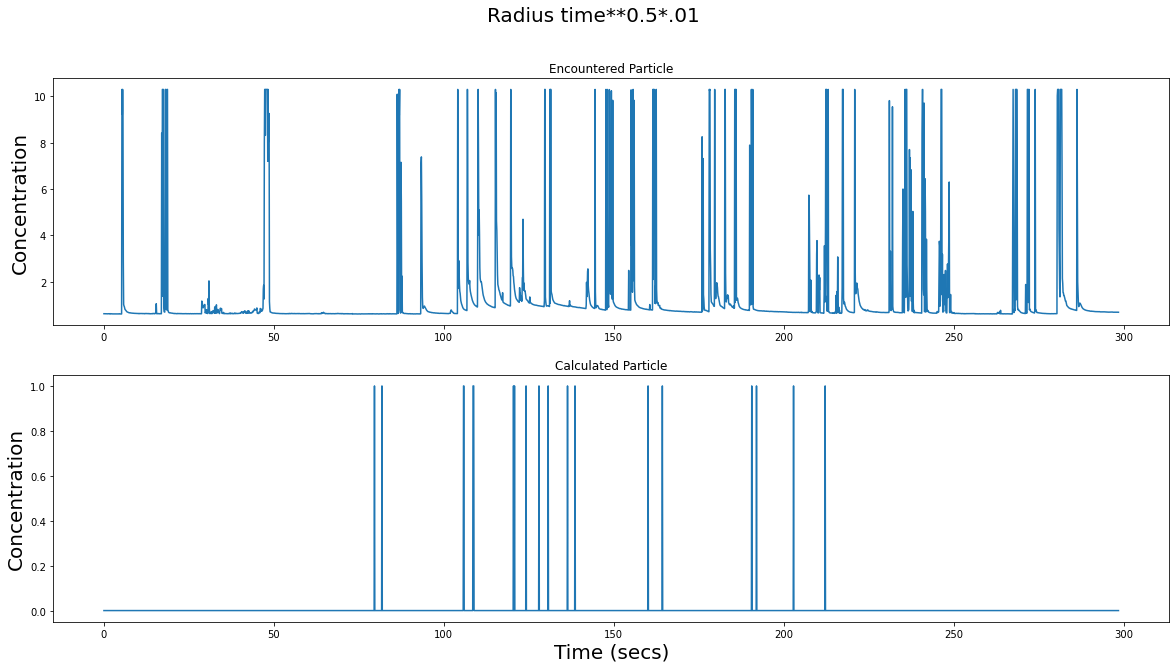

In [55]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(20,10))
ax1.plot(df.sync_time, df.odor)
ax1.set_ylabel('Concentration', fontsize=20)
ax1.title.set_text('Encountered Particle')
ax2.plot(df.sync_time,df.odor_expected)
ax2.set_xlabel('Time (secs)', fontsize=20)
ax2.set_ylabel('Concentration', fontsize=20)
ax2.title.set_text('Calculated Particle')

f.suptitle('Radius time**0.5*.01', fontsize =20)


### Full version of the odor to wind 

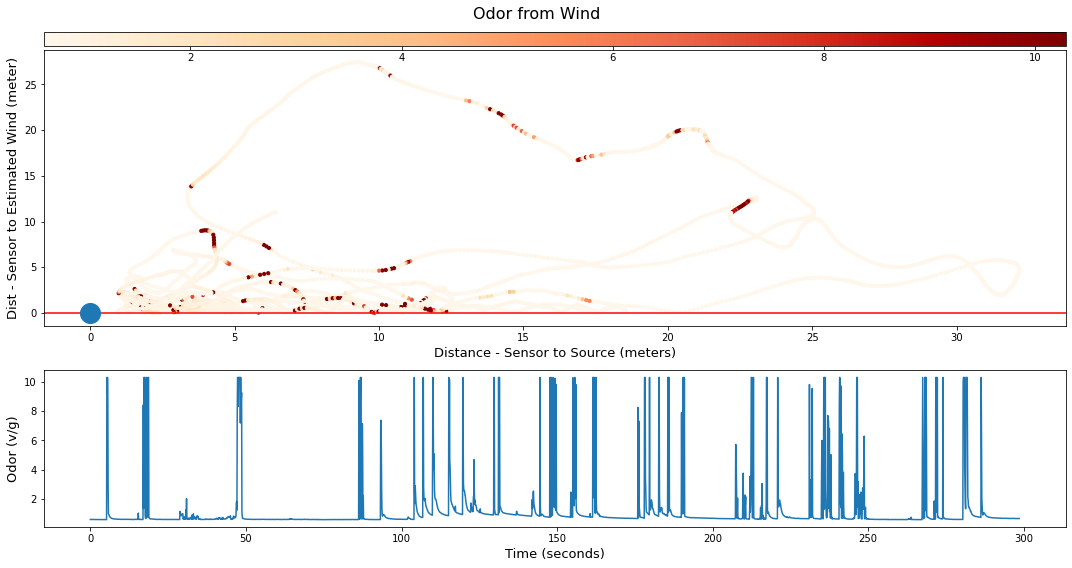

In [81]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(15,8) , gridspec_kw={'height_ratios': [15,8]})

f.suptitle('Odor from Wind', fontsize = 16)
#ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
# area = df.radius**2*4*m.pi #area
# ax1.scatter(df.odor_from_source[::30], df.mock[::30],  facecolors='none', edgecolors='b', s = area[::30])
var = ax1.scatter(df.odor_from_source, df.odor_from_wind, cmap = 'OrRd', c = df.odor,  s = 10)
ax1.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 13)
ax1.set_ylabel('Dist - Sensor to Estimated Wind (meter)' , fontsize = 13)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'horizontal')

ax2.plot(df.sync_time,df.odor)
ax2.set_xlabel('Time (seconds)' , fontsize = 13)
ax2.set_ylabel('Odor (v/g)' , fontsize = 13)
f.tight_layout()
f.savefig('test_plot_up.jpeg')

### Plotting 2d version of the video animation

In [60]:
## ABOVE THRESHOLD
query = 'odor >= 8'
df_threshold_up =df.query(query)

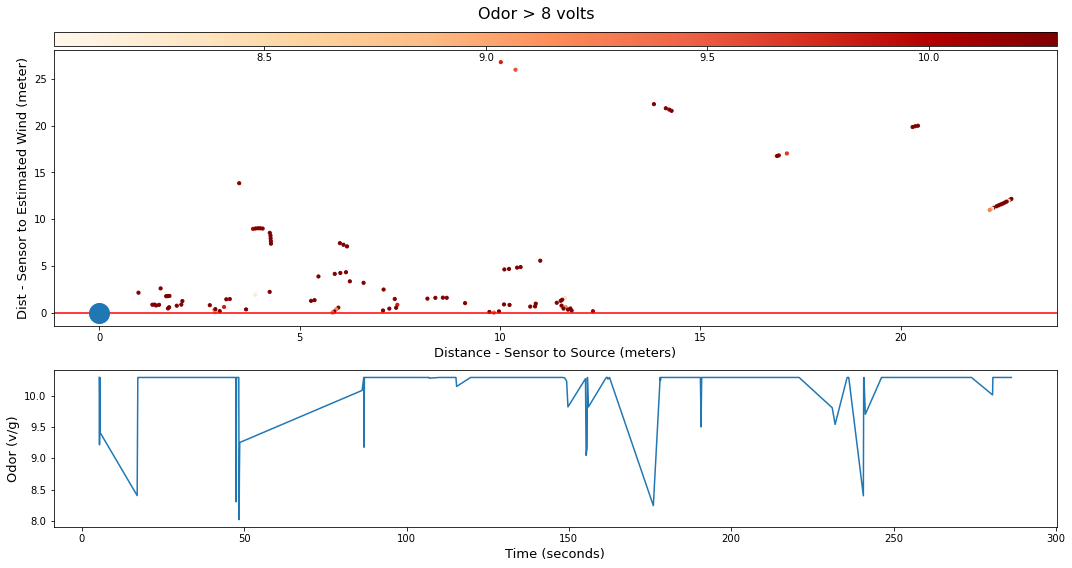

In [77]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(15,8) , gridspec_kw={'height_ratios': [15,8]})
# gs1 = f.add_gridspec(nrows=2, ncols=1, left=0.05, right=0.48, wspace=0.05)
f.suptitle('Odor > 8 volts', fontsize = 16)
#ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
# area = df_threshold_up.radius**2*4*m.pi #area
# ax1.scatter(df_threshold_up.odor_from_source, df_threshold_up.mock,  facecolors='none', edgecolors='b', s = area)
var = ax1.scatter(df_threshold_up.odor_from_source, df_threshold_up.odor_from_wind, cmap = 'OrRd', c = df_threshold_up.odor,  s = 10)
ax1.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 13)
ax1.set_ylabel('Dist - Sensor to Estimated Wind (meter)' , fontsize = 13)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'horizontal')

ax2.plot(df_threshold_up.sync_time,df_threshold_up.odor)
ax2.set_xlabel('Time (seconds)' , fontsize = 13)
ax2.set_ylabel('Odor (v/g)' , fontsize = 13)
f.tight_layout()
f.savefig('test_plot_up.jpeg')

In [62]:
## ABOVE THRESHOLD
query_down = 'odor < 8'
df_threshold_down =df.query(query_down)

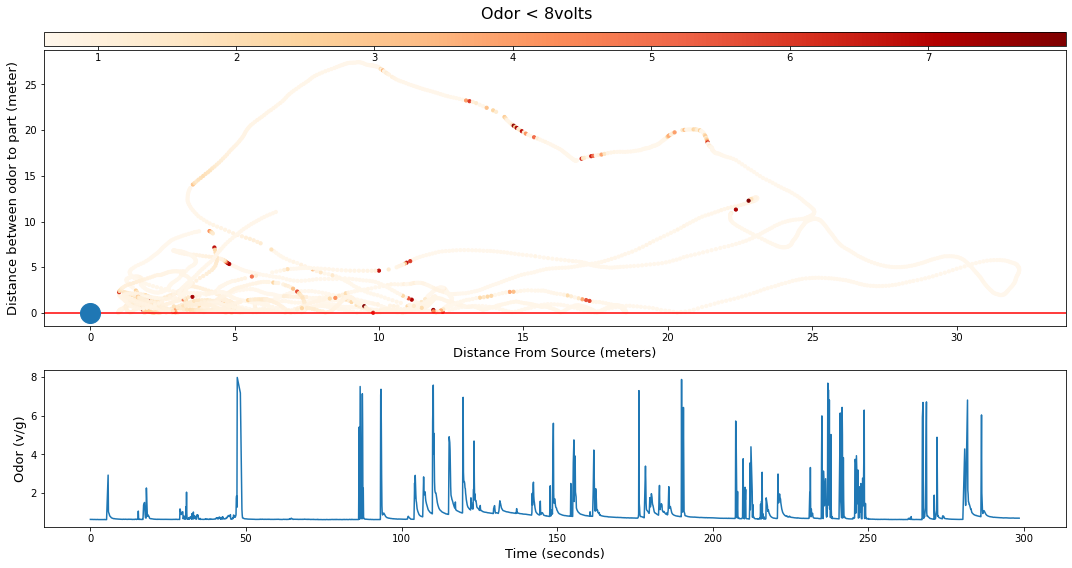

In [63]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(15,8) , gridspec_kw={'height_ratios': [15,8]})
# gs1 = f.add_gridspec(nrows=2, ncols=1, left=0.05, right=0.48, wspace=0.05)
f.suptitle('Odor < 8volts', fontsize = 16)
#ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df_threshold_down.odor_from_source, df_threshold_down.odor_from_wind, cmap = 'OrRd', c = df_threshold_down.odor,  s = 10)
ax1.set_xlabel('Distance From Source (meters)' , fontsize = 13)
ax1.set_ylabel('Distance between odor to part (meter)' , fontsize = 13)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'horizontal')

ax2.plot(df_threshold_down.sync_time,df_threshold_down.odor)
ax2.set_xlabel('Time (seconds)' , fontsize = 13)
ax2.set_ylabel('Odor (v/g)' , fontsize = 13)
f.tight_layout()
f.savefig('test_plot_down.jpeg')